# CheXNet X-Ray Pathology Detection

This notebook is a quick "UI" for the a trained CheXNet model for use in detecting one of 14 pathoologies present in a given chest X-Ray image.

[CheXNet: Radiologist-Level Pneumonia Detection on Chest X-Rays with Deep Learning.](http://arxiv.org/abs/1711.05225)

A few example of test images, and their respective pathologies, that have been evaluated by the model can be seen below : 

<table align="center">
    <tr>
        <td>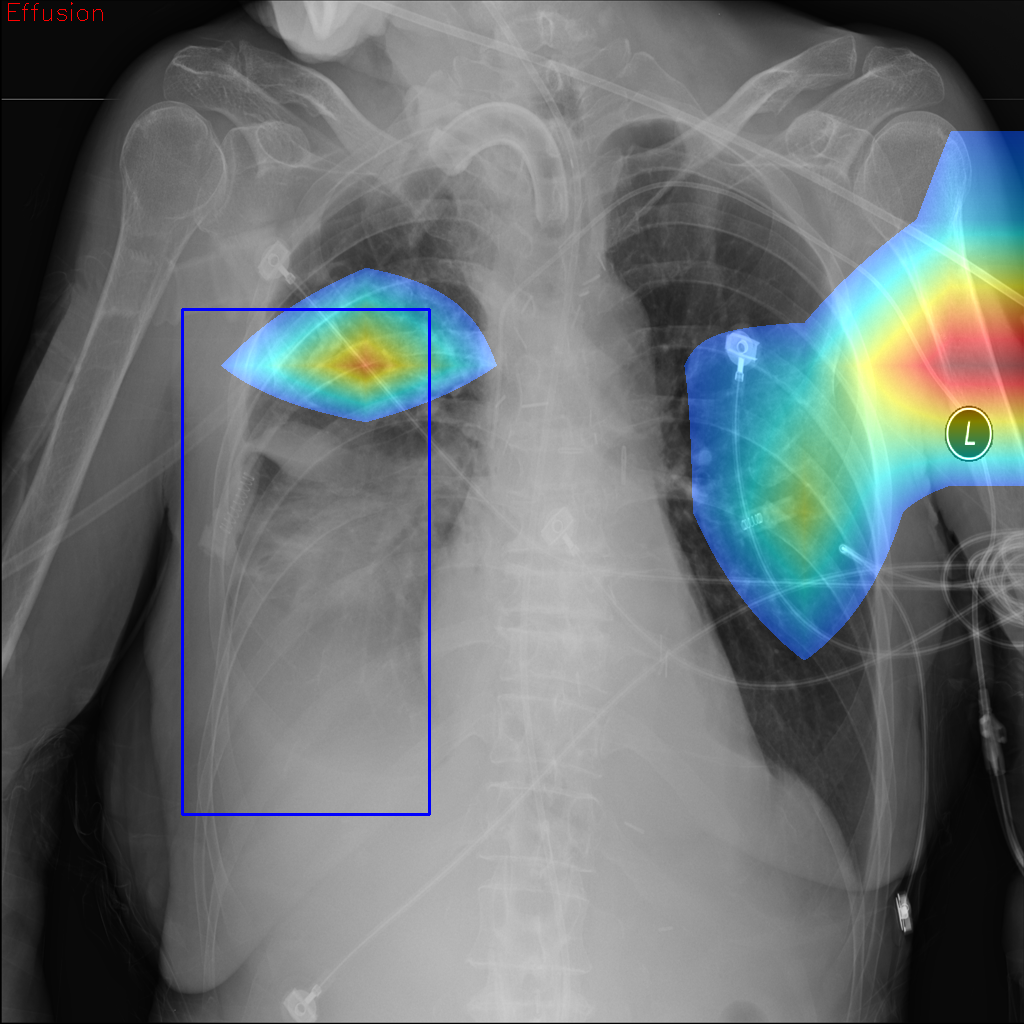Effusion</td>
        <td>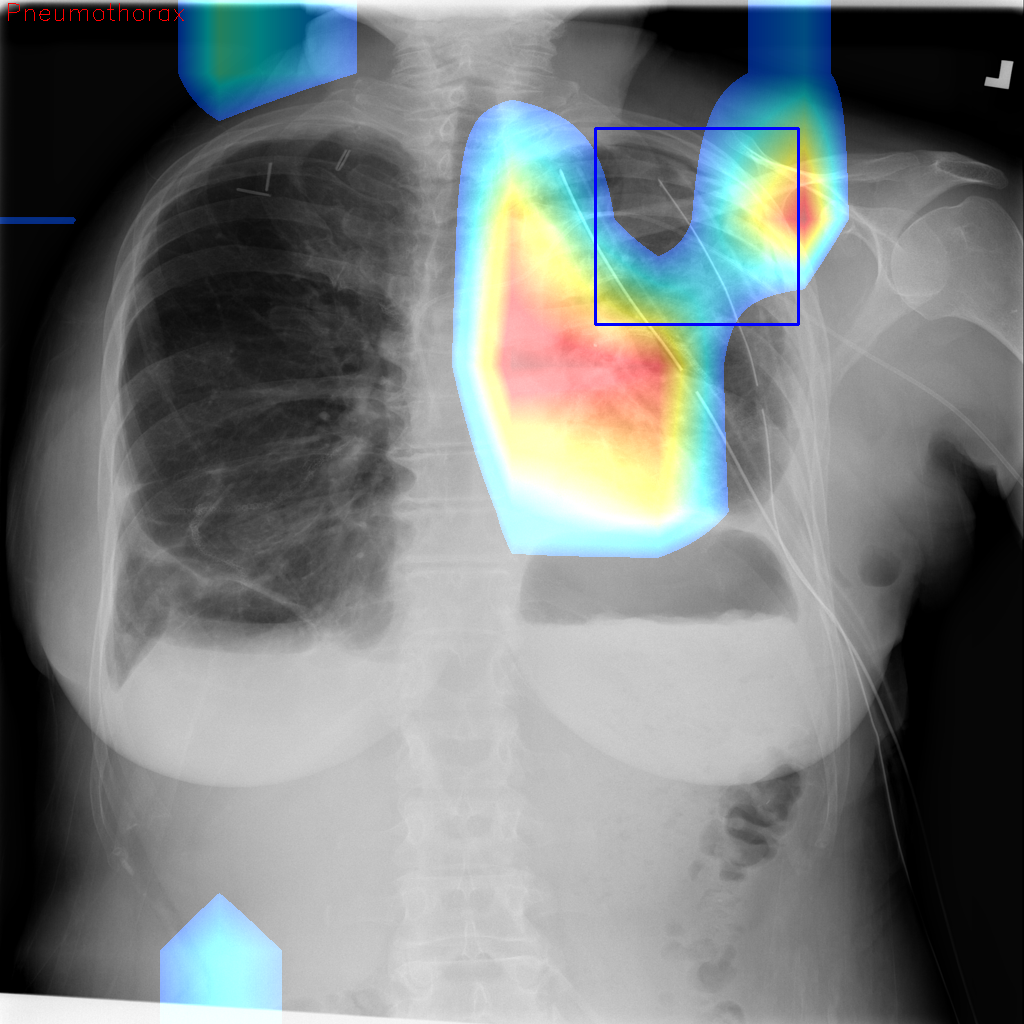Pneumothorax</td>
        <td>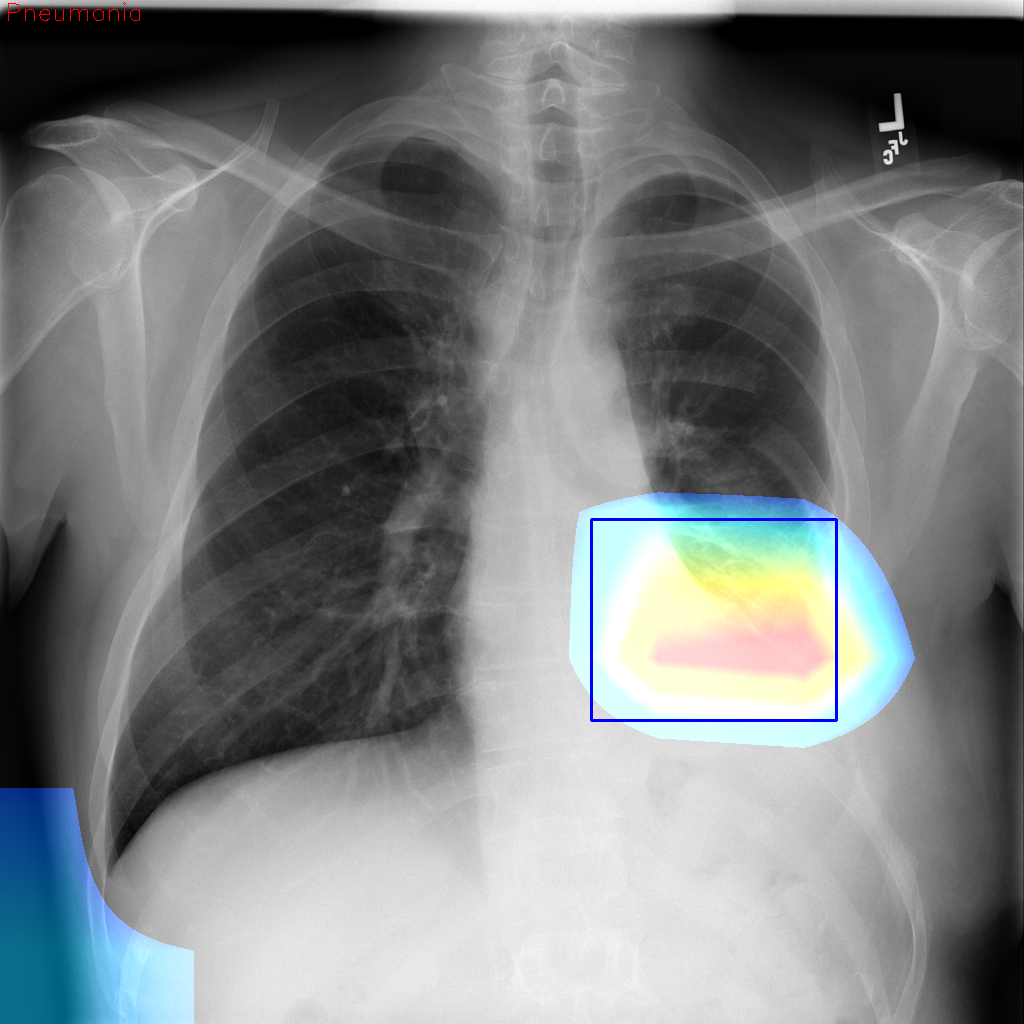Pneumonia</td>
    </tr>
</table>


The examples above also include the application of what is called a [Class Activation Map](http://cnnlocalization.csail.mit.edu/) which has been shown to provide an unsupervised form of object localization on previous tasks such as object localization on models that have been trained on the ImageNet dataset.

The goal of this implementation and the surrounding tooling to enable someone whom is interested, generally, in Machine Learning (ML) and would like to understand better what an example end to end Machine Learning pipeline might look like. All of the tools and utilities that are used within this implementation are open source, highlighting the open source and open science approach that I think is necessary to allow for further adoption of ML solutions.

The pipeline is general enough that one can swap the input portion and model portion of the pipelines to allow for other applications. This example is specific to computer vision, however one can feasibly "slot in" another application using the same tooling and rough outline of a pipeline.

This is an end to end serving pipeline example and we can see the outline of the architecture below. 

<img src="XRay_Webapp_High_Level_Pipeline.png" width="600" align="center" />

The goal of this notebook is to demo this end to end environment to allow us to see how all of the components of the system interact, along with measure throughput of the entire pipeline, as well.


### Supporting Services

Here we will define some of the supporting services code used to publish and consume messages from a Kafka topic. Below are some defintions of what is being defined.

`kafka_inference_topic` : A Kafka topic that has an agent listening for any images published. This agent will retrieve the new image published to the topic and query our trained classification model and return a classification result for us to view.

`kafka_results_topic` : A Kafka topic that is used to return results from an image that was previously published to the `kafka_inference_topic` defined above. This will return both the resulting image with a [Class Activation Map](http://cnnlocalization.csail.mit.edu/) overlay, while also providing a vector of respective probabilities of what class the image belongs to.

`publish_to_kafka()` : Method used for publishing messages to the respective Kafka topics.

In [2]:
from confluent_kafka import Producer, Consumer, KafkaError, KafkaException
import fileupload
import io
from IPython.display import display
import json
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import sys

%matplotlib inline

kafka_inference_topic = 'xray.inference.image'
kafka_results_topic = 'xray.results.image'
kafka_broker = '172.23.0.5:9092'
results_consumer_group_id = 'xray.inference.consumers'
offset_reset = 'latest'

class_names = ["Atelectasis","Cardiomegaly","Effusion",
               "Infiltration","Mass","Nodule",
               "Pneumonia","Pneumothorax","Consolidation",
               "Edema",",Emphysema","Fibrosis",
               "Pleural_Thickening","Hernia"]


producer = Producer({'bootstrap.servers': kafka_broker})

c = Consumer({
    'bootstrap.servers': kafka_broker,
    'group.id': results_consumer_group_id,
    'auto.offset.reset': offset_reset
})

c.subscribe([kafka_results_topic])

def create_barchart(prediction_array):
    """Create a barchart for predictions
    
    Arguments:
        prediction_array {numpy array} -- Array of predictions returned from CheXNet Model
    """
    y_pos = class_names

    plt.barh(y_pos, prediction_array, align='center', alpha=0.5)
    plt.yticks(y_pos, class_names)
    plt.xlabel('Probability')
    plt.title("Probability of given pathology")
    plt.savefig("barchart.png")
    
def collect_results():
    """
    collect results from kafka of our classification
    """
    while True:
        msg = c.poll(0)
        if msg is None:
            print("No new message!")
            return
        if msg.error():
            if msg.error().code() == KafkaError._PARTITION_EOF:
                sys.stderr.write('%% %s [%d] reached end of offset %d\n' %
                                 (msg.topic(), msg.partition(), msg.offset()))
            else:
                raise KafkaException(msg.error())
        else:
            # Well formed messaged
            sys.stderr.write('%% %s [%d] at offset %d with key %s: \n' %
                             (msg.topic(), msg.partition(), msg.offset(),
                              str(msg.key())))
            msg_contents = json.loads(msg.value())
            img_bytes = msg_contents['image'].encode('latin-1')
            aurocs = msg_contents['aurocs'][0]
            img_bytes_array = bytearray()
            img_bytes_array.extend(img_bytes)
            image = Image.open(io.BytesIO(img_bytes_array))
            return aurocs, image
        return

## Image Upload

In the code below we are uploading an image that can then be feed through out model and given a classification according to the 14 potential pathologies present in the training dataset.

In [3]:
upload_widget = fileupload.FileUploadWidget()

def cb(change):
    decoded = io.StringIO(change['owner'].data.decode('latin-1'))
    filename = change['owner'].filename
    print('Uploaded `{}` ({:.2f} kB)'.format(
        filename, len(decoded.read()) / 2 **10))

upload_widget.observe(cb, names='data')
display(upload_widget)

FileUploadWidget(label='Browse', _dom_classes=('widget_item', 'btn-group'))

Uploaded `00000001_001.png` (434.23 kB)


### Review Image

Now that we've uploaded a respective image to the notebook we can quickly view this image to ensure that it is the image that we're expecting. It'll also allow us to compare the original image with the image that is returned from the CheXNet Client that has the heatmap overlay.

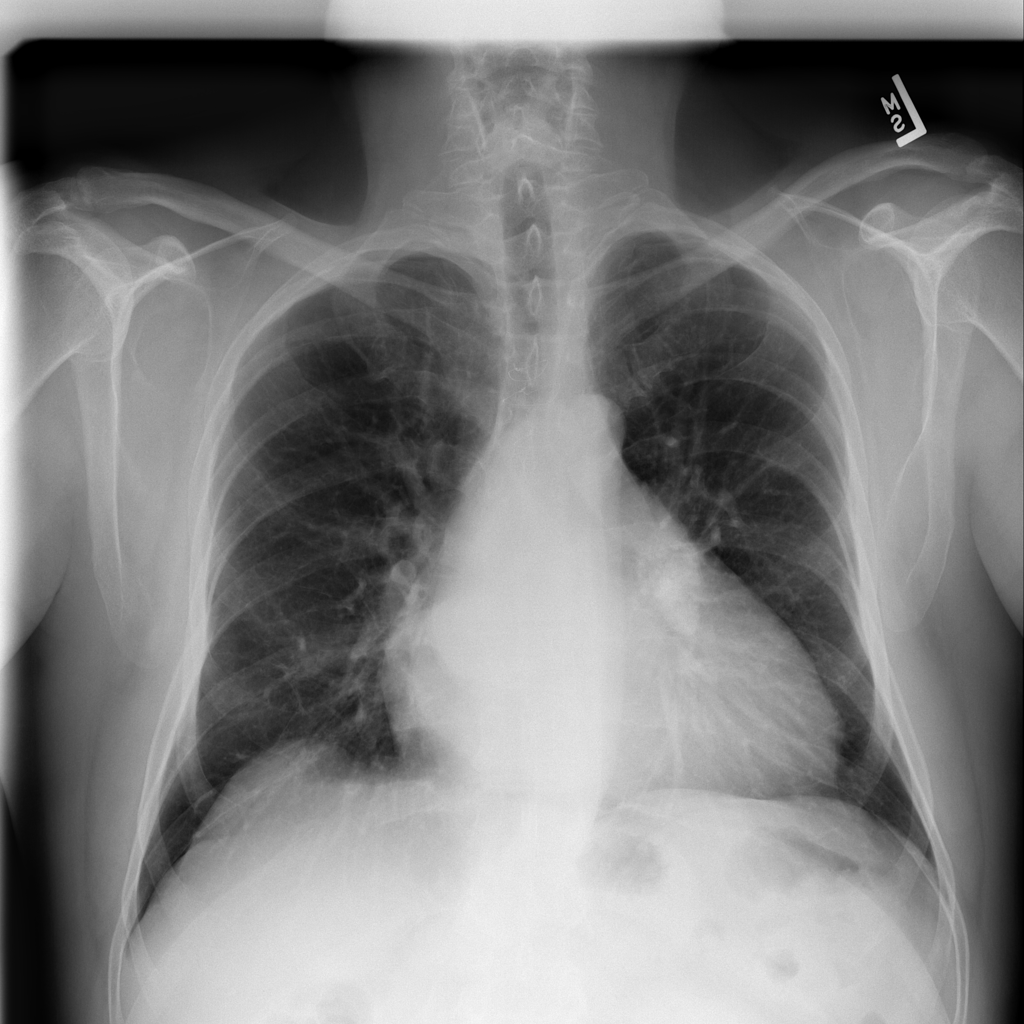

In [4]:
img_bytes = io.BytesIO(upload_widget.data)
img = Image.open(img_bytes)
display(img)

In [5]:
producer.produce(kafka_inference_topic, value=img_bytes.getvalue())
producer.flush()

0

% xray.results.image [0] at offset 5 with key None: 


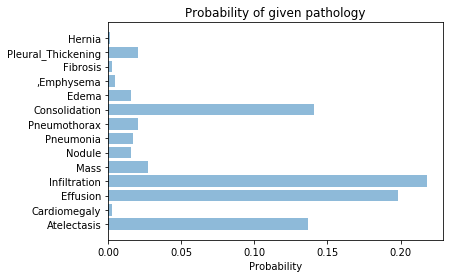

In [7]:
aurocs, cam_img = collect_results()
aurocs = np.asarray(aurocs)
create_barchart(aurocs)

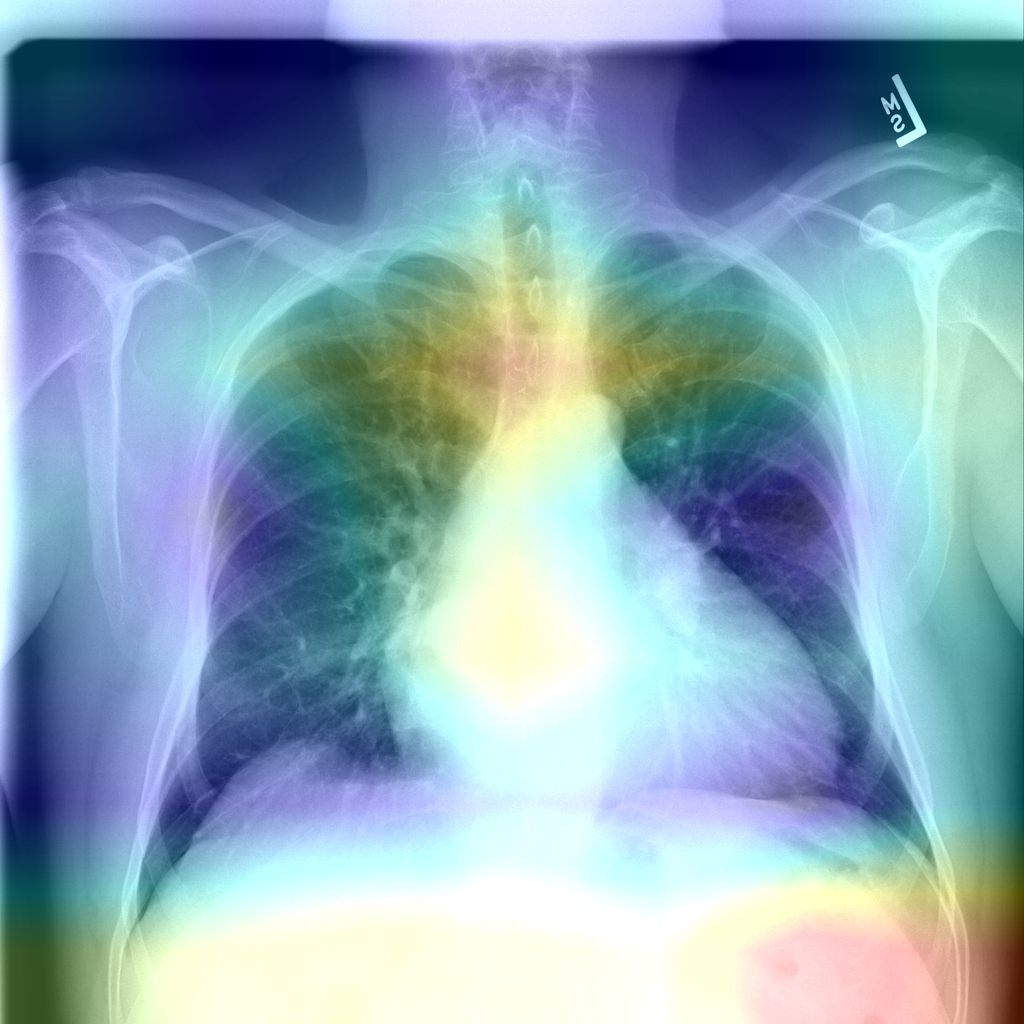

In [8]:
display(cam_img)